In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 10 14:31:28 2020

@author: johannesniemelainen
"""



'\nCreated on Thu Dec 10 14:31:28 2020\n\n@author: johannesniemelainen\n'

In [54]:
## Import all needed modules and tools

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Lifelines module needed for survival analysis

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times


# HELSINKI



In [55]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## below is the first one I did for Helsinki data. The base event happens in 2004 local elections
## and '08, '12, and '17 data is appended to that


## Load necessary dataframes
HKI_04 = pd.read_csv("030_kvaa_2004_101.csv", sep=",", skiprows=1, engine="python")
HKI_08 = pd.read_csv("210_kvaa_2008_108.csv", sep=",", skiprows=1, engine="python")
HKI_12 = pd.read_csv("210_kvaa_2012_108.csv", sep=",", skiprows=1, engine="python")
HKI_17 = pd.read_csv("210_kvaa_2017_108.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
HKI_04 = HKI_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
HKI_04[["Name", "Party", "Town"]] = HKI_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
HKI_04[["Last", "First"]] = HKI_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
HKI_04 = HKI_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
HKI_04 = HKI_04[HKI_04.Elected_04 == 1]

## Clear data
HKI_04['Sitting'] = HKI_04['Sitting'].replace(".", 0)

## Create a year number
HKI_04["Year"] = 2004

## Repeate the same process as in 04 elections
HKI_08 = HKI_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
HKI_08[["Name", "Party", "Town"]] = HKI_08.Candidate.str.split(" / ", expand=True)
HKI_08[["Last", "First"]] = HKI_08.Name.str.rsplit(n=1, expand=True)
HKI_08 = HKI_08.drop(["Candidate"], axis=1)
HKI_08 = HKI_08[HKI_08.Elected_08 == 1]
HKI_08['Sitting'] = HKI_08['Sitting'].replace(".", 0)
HKI_04["Year"] = 2008

## Repeate the same process as in 04 elections
HKI_12 = HKI_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
HKI_12[["Name", "Party", "Town"]] = HKI_12.Candidate.str.split(" / ", expand=True)
HKI_12[["Last", "First"]] = HKI_12.Name.str.rsplit(n=1, expand=True)
HKI_12 = HKI_12.drop(["Candidate"], axis=1)
HKI_12 = HKI_12[HKI_12.Elected_12 == 1]
HKI_12['Sitting'] = HKI_12['Sitting'].replace("-", 0)
HKI_04["Year"] = 2012

## Repeate the same process as in 04 elections
HKI_17 = HKI_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
HKI_17[["Name", "Party", "Town"]] = HKI_17.Candidate.str.split(" / ", expand=True)
HKI_17[["Last", "First"]] = HKI_17.Name.str.rsplit(n=1, expand=True)
HKI_17 = HKI_17.drop(["Candidate"], axis=1)
HKI_17 = HKI_17[HKI_17.Elected_17 == 1]
HKI_17['Sitting'] = HKI_17['Sitting'].replace("-", 0)
HKI_04["Year"] = 2017

## Create one dataframe from the data
HKI_append = HKI_04.append(HKI_08)
HKI_append = HKI_append.append(HKI_12)
HKI_append = HKI_append.append(HKI_17)

## Fill NAs in Eleceted_year columns
HKI_append = HKI_append.fillna(value=0)

## Change datatypes
HKI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = HKI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
HKI_new = HKI_append.groupby(HKI_append['Name']).aggregate(aggregation_functions)

HKI_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
HKI_new_04 = HKI_new[HKI_new.Elected_04 == 1]

## Create a start year for survival function
HKI_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (HKI_new_04['Elected_08'] == 0),
    (HKI_new_04['Elected_12'] == 0),
    (HKI_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

HKI_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
HKI_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
HKI_new_04["Event"] = ["0" if x=="2021" else "1" for x in HKI_new_04["Stop_year"]]
HKI_new_04["Event"] = HKI_new_04.Event.astype("float64")

## Create datetime objects
HKI_new_04['Start_year'] = pd.to_datetime(HKI_new_04['Start_year'])
HKI_new_04['Stop_year'] = pd.to_datetime(HKI_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
HKI_new_04['Time'] = np.rint(((HKI_new_04['Stop_year'] - HKI_new_04['Start_year']).dt.days)/365)



<ipython-input-55-a818b79702f3>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HKI_new_04["Start_year"] = "2004"
<ipython-input-55-a818b79702f3>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HKI_new_04['Stop_year'] = np.select(conditions, values)
/Users/johannesniemelainen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

Median for persistence is: 8.0


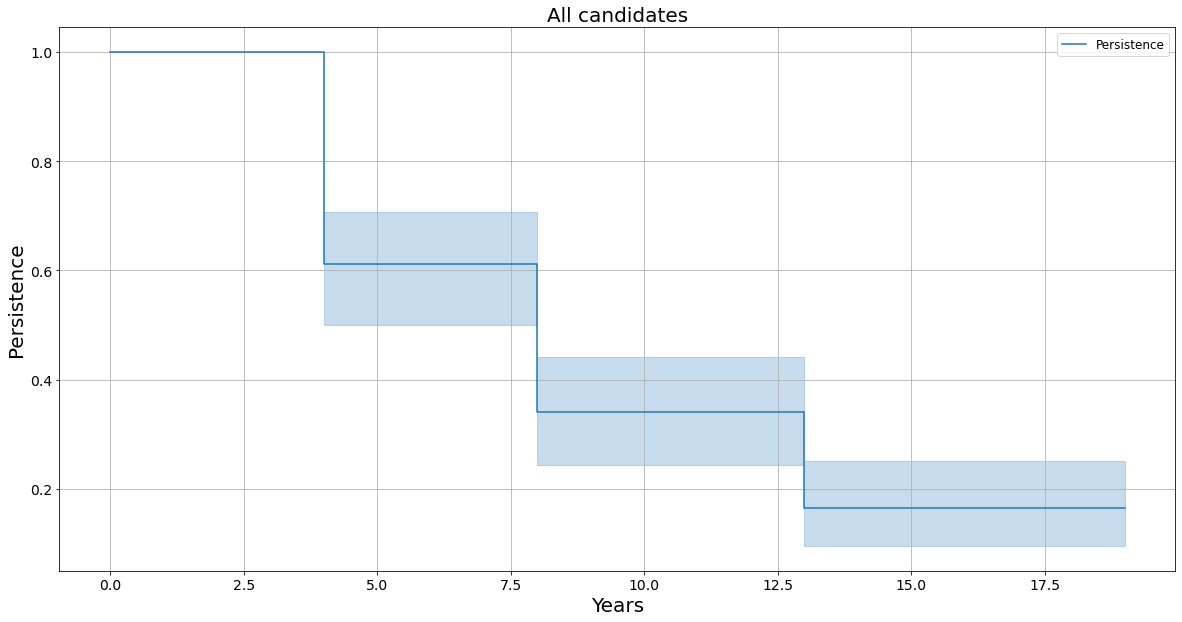

In [56]:
## Here is a basic plotting for Helsinki data only.

##Get the Time and Event 
Time = HKI_new_04["Time"]
Event = HKI_new_04["Event"]

kmf.fit(Time, Event, timeline=range(0,20,1))

kmf.survival_function_
kmf.cumulative_density_

ax1 = kmf.plot(label='Persistence')

## Draw the grid
ax1.grid()

## Y and X axes labels and font size
ax1.set_xlabel('Years', size = 20)
ax1.set_ylabel('Persistence', size = 20)

## Plot title and size
ax1.set_title('All candidates', size = 20)

## Legend location and fontsize
ax1.legend(loc='upper right', fontsize = 12)

## Save the plot
plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_HKI_04_all.png')

## Determine the median value
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median
print("Median for persistence is:",median_)



# UUSIMAA


In [57]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## Uusimaa electoral district


## Load necessary dataframes
UUSI_04 = pd.read_csv("030_kvaa_2004_102.csv", sep=",", skiprows=1, engine="python")
UUSI_08 = pd.read_csv("220_kvaa_2008_109.csv", sep=",", skiprows=1, engine="python")
UUSI_12 = pd.read_csv("220_kvaa_2012_109.csv", sep=",", skiprows=1, engine="python")
UUSI_17 = pd.read_csv("220_kvaa_2017_109.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
UUSI_04 = UUSI_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
UUSI_04[["Name", "Party", "Town"]] = UUSI_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
UUSI_04[["Last", "First"]] = UUSI_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
UUSI_04 = UUSI_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
UUSI_04 = UUSI_04[UUSI_04.Elected_04 == 1]

## Clear data
UUSI_04['Sitting'] = UUSI_04['Sitting'].replace(".", 0)

## Create a year number
UUSI_04["Year"] = 2004

## Repeate the same process as in 04 elections
UUSI_08 = UUSI_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
UUSI_08[["Name", "Party", "Town"]] = UUSI_08.Candidate.str.split(" / ", expand=True)
UUSI_08[["Last", "First"]] = UUSI_08.Name.str.rsplit(n=1, expand=True)
UUSI_08 = UUSI_08.drop(["Candidate"], axis=1)
UUSI_08 = UUSI_08[UUSI_08.Elected_08 == 1]
UUSI_08['Sitting'] = UUSI_08['Sitting'].replace(".", 0)
UUSI_04["Year"] = 2008

## Repeate the same process as in 04 elections
UUSI_12 = UUSI_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
UUSI_12[["Name", "Party", "Town"]] = UUSI_12.Candidate.str.split(" / ", expand=True)
UUSI_12[["Last", "First"]] = UUSI_12.Name.str.rsplit(n=1, expand=True)
UUSI_12 = UUSI_12.drop(["Candidate"], axis=1)
UUSI_12 = UUSI_12[UUSI_12.Elected_12 == 1]
UUSI_12['Sitting'] = UUSI_12['Sitting'].replace("-", 0)
UUSI_04["Year"] = 2012

## Repeate the same process as in 04 elections
UUSI_17 = UUSI_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
UUSI_17[["Name", "Party", "Town"]] = UUSI_17.Candidate.str.split(" / ", expand=True)
UUSI_17[["Last", "First"]] = UUSI_17.Name.str.rsplit(n=1, expand=True)
UUSI_17 = UUSI_17.drop(["Candidate"], axis=1)
UUSI_17 = UUSI_17[UUSI_17.Elected_17 == 1]
UUSI_17['Sitting'] = UUSI_17['Sitting'].replace("-", 0)
UUSI_04["Year"] = 2017

## Create one dataframe from the data
UUSI_append = UUSI_04.append(UUSI_08)
UUSI_append = UUSI_append.append(UUSI_12)
UUSI_append = UUSI_append.append(UUSI_17)

## Fill NAs in Eleceted_year columns
UUSI_append = UUSI_append.fillna(value=0)

## Change datatypes
UUSI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = UUSI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
UUSI_new = UUSI_append.groupby(UUSI_append['Name']).aggregate(aggregation_functions)

UUSI_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
UUSI_new_04 = UUSI_new[UUSI_new.Elected_04 == 1]

## Create a start year for survival function
UUSI_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (UUSI_new_04['Elected_08'] == 0),
    (UUSI_new_04['Elected_12'] == 0),
    (UUSI_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

UUSI_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
UUSI_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
UUSI_new_04["Event"] = ["0" if x=="2021" else "1" for x in UUSI_new_04["Stop_year"]]
UUSI_new_04["Event"] = UUSI_new_04.Event.astype("float64")

## Create datetime objects
UUSI_new_04['Start_year'] = pd.to_datetime(UUSI_new_04['Start_year'])
UUSI_new_04['Stop_year'] = pd.to_datetime(UUSI_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
UUSI_new_04['Time'] = np.rint(((UUSI_new_04['Stop_year'] - UUSI_new_04['Start_year']).dt.days)/365)




<ipython-input-57-816095343dfa>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UUSI_new_04["Start_year"] = "2004"
<ipython-input-57-816095343dfa>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UUSI_new_04['Stop_year'] = np.select(conditions, values)
/Users/johannesniemelainen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [58]:
## Shorten the KaplanMeierFitter function

kmf = KaplanMeierFitter()

## General settings for plotting

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

Median for persistence is: 8.0


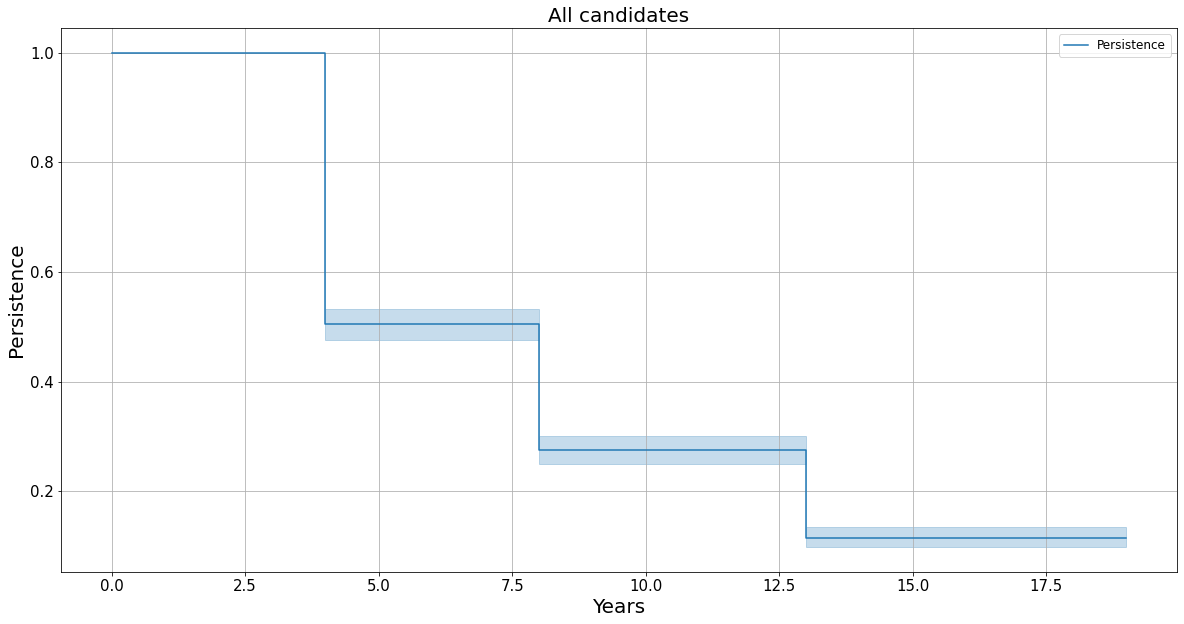

In [59]:
## Here is a basic plotting for Uusimaa data only. This is an example, the actual analysis is done in another notebook

##Get the Time and Event 
Time = UUSI_new_04["Time"]
Event = UUSI_new_04["Event"]

kmf.fit(Time, Event, timeline=range(0,20,1))

kmf.survival_function_
kmf.cumulative_density_

ax1 = kmf.plot(label='Persistence')

## Draw the grid
ax1.grid()

## Y and X axes labels and font size
ax1.set_xlabel('Years', size = 20)
ax1.set_ylabel('Persistence', size = 20)

## Plot title and size
ax1.set_title('All candidates', size = 20)

## Legend location and fontsize
ax1.legend(loc='upper right', fontsize = 12)

## Save the plot
plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_UUSI_04_all.png')

## Determine the median value
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median
print("Median for persistence is:",median_)





# VARSINAIS-SUOMI

In [60]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## Varsinais-SUomi electoral district


## Load necessary dataframes
VARSI_04 = pd.read_csv("030_kvaa_2004_103.csv", sep=",", skiprows=1, engine="python")
VARSI_08 = pd.read_csv("230_kvaa_2008_110.csv", sep=",", skiprows=1, engine="python")
VARSI_12 = pd.read_csv("230_kvaa_2012_110.csv", sep=",", skiprows=1, engine="python")
VARSI_17 = pd.read_csv("230_kvaa_2017_110.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
VARSI_04 = VARSI_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
VARSI_04[["Name", "Party", "Town"]] = VARSI_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
VARSI_04[["Last", "First"]] = VARSI_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
VARSI_04 = VARSI_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
VARSI_04 = VARSI_04[VARSI_04.Elected_04 == 1]

## Clear data
VARSI_04['Sitting'] = VARSI_04['Sitting'].replace(".", 0)

## Create a year number
VARSI_04["Year"] = 2004

## Repeate the same process as in 04 elections
VARSI_08 = VARSI_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
VARSI_08[["Name", "Party", "Town"]] = VARSI_08.Candidate.str.split(" / ", expand=True)
VARSI_08[["Last", "First"]] = VARSI_08.Name.str.rsplit(n=1, expand=True)
VARSI_08 = VARSI_08.drop(["Candidate"], axis=1)
VARSI_08 = VARSI_08[VARSI_08.Elected_08 == 1]
VARSI_08['Sitting'] = VARSI_08['Sitting'].replace(".", 0)
VARSI_04["Year"] = 2008

## Repeate the same process as in 04 elections
VARSI_12 = VARSI_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
VARSI_12[["Name", "Party", "Town"]] = VARSI_12.Candidate.str.split(" / ", expand=True)
VARSI_12[["Last", "First"]] = VARSI_12.Name.str.rsplit(n=1, expand=True)
VARSI_12 = VARSI_12.drop(["Candidate"], axis=1)
VARSI_12 = VARSI_12[VARSI_12.Elected_12 == 1]
VARSI_12['Sitting'] = VARSI_12['Sitting'].replace("-", 0)
VARSI_04["Year"] = 2012

## Repeate the same process as in 04 elections
VARSI_17 = VARSI_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
VARSI_17[["Name", "Party", "Town"]] = VARSI_17.Candidate.str.split(" / ", expand=True)
VARSI_17[["Last", "First"]] = VARSI_17.Name.str.rsplit(n=1, expand=True)
VARSI_17 = VARSI_17.drop(["Candidate"], axis=1)
VARSI_17 = VARSI_17[VARSI_17.Elected_17 == 1]
VARSI_17['Sitting'] = VARSI_17['Sitting'].replace("-", 0)
VARSI_04["Year"] = 2017

## Create one dataframe from the data
VARSI_append = VARSI_04.append(VARSI_08)
VARSI_append = VARSI_append.append(VARSI_12)
VARSI_append = VARSI_append.append(VARSI_17)

## Fill NAs in Eleceted_year columns
VARSI_append = VARSI_append.fillna(value=0)

## Change datatypes
VARSI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = VARSI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
VARSI_new = VARSI_append.groupby(VARSI_append['Name']).aggregate(aggregation_functions)

VARSI_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
VARSI_new_04 = VARSI_new[VARSI_new.Elected_04 == 1]

## Create a start year for survival function
VARSI_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (VARSI_new_04['Elected_08'] == 0),
    (VARSI_new_04['Elected_12'] == 0),
    (VARSI_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

VARSI_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
VARSI_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
VARSI_new_04["Event"] = ["0" if x=="2021" else "1" for x in VARSI_new_04["Stop_year"]]
VARSI_new_04["Event"] = VARSI_new_04.Event.astype("float64")

## Create datetime objects
VARSI_new_04['Start_year'] = pd.to_datetime(VARSI_new_04['Start_year'])
VARSI_new_04['Stop_year'] = pd.to_datetime(VARSI_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
VARSI_new_04['Time'] = np.rint(((VARSI_new_04['Stop_year'] - VARSI_new_04['Start_year']).dt.days)/365)





<ipython-input-60-a85f9144ec2e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VARSI_new_04["Start_year"] = "2004"
<ipython-input-60-a85f9144ec2e>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VARSI_new_04['Stop_year'] = np.select(conditions, values)
/Users/johannesniemelainen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [61]:
VARSI_new_04.shape

(1314, 13)

# SATAKUNTA

In [62]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## SATAnais-SUomi electoral district


## Load necessary dataframes
SATA_04 = pd.read_csv("030_kvaa_2004_104.csv", sep=",", skiprows=1, engine="python")
SATA_08 = pd.read_csv("240_kvaa_2008_111.csv", sep=",", skiprows=1, engine="python")
SATA_12 = pd.read_csv("240_kvaa_2012_111.csv", sep=",", skiprows=1, engine="python")
SATA_17 = pd.read_csv("240_kvaa_2017_111.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
SATA_04 = SATA_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
SATA_04[["Name", "Party", "Town"]] = SATA_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
SATA_04[["Last", "First"]] = SATA_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
SATA_04 = SATA_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
SATA_04 = SATA_04[SATA_04.Elected_04 == 1]

## Clear data
SATA_04['Sitting'] = SATA_04['Sitting'].replace(".", 0)

## Create a year number
SATA_04["Year"] = 2004

## Repeate the same process as in 04 elections
SATA_08 = SATA_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
SATA_08[["Name", "Party", "Town"]] = SATA_08.Candidate.str.split(" / ", expand=True)
SATA_08[["Last", "First"]] = SATA_08.Name.str.rsplit(n=1, expand=True)
SATA_08 = SATA_08.drop(["Candidate"], axis=1)
SATA_08 = SATA_08[SATA_08.Elected_08 == 1]
SATA_08['Sitting'] = SATA_08['Sitting'].replace(".", 0)
SATA_04["Year"] = 2008

## Repeate the same process as in 04 elections
SATA_12 = SATA_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
SATA_12[["Name", "Party", "Town"]] = SATA_12.Candidate.str.split(" / ", expand=True)
SATA_12[["Last", "First"]] = SATA_12.Name.str.rsplit(n=1, expand=True)
SATA_12 = SATA_12.drop(["Candidate"], axis=1)
SATA_12 = SATA_12[SATA_12.Elected_12 == 1]
SATA_12['Sitting'] = SATA_12['Sitting'].replace("-", 0)
SATA_04["Year"] = 2012

## Repeate the same process as in 04 elections
SATA_17 = SATA_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
SATA_17[["Name", "Party", "Town"]] = SATA_17.Candidate.str.split(" / ", expand=True)
SATA_17[["Last", "First"]] = SATA_17.Name.str.rsplit(n=1, expand=True)
SATA_17 = SATA_17.drop(["Candidate"], axis=1)
SATA_17 = SATA_17[SATA_17.Elected_17 == 1]
SATA_17['Sitting'] = SATA_17['Sitting'].replace("-", 0)
SATA_04["Year"] = 2017

## Create one dataframe from the data
SATA_append = SATA_04.append(SATA_08)
SATA_append = SATA_append.append(SATA_12)
SATA_append = SATA_append.append(SATA_17)

## Fill NAs in Eleceted_year columns
SATA_append = SATA_append.fillna(value=0)

## Change datatypes
SATA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = SATA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
SATA_new = SATA_append.groupby(SATA_append['Name']).aggregate(aggregation_functions)

SATA_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
SATA_new_04 = SATA_new[SATA_new.Elected_04 == 1]

## Create a start year for survival function
SATA_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (SATA_new_04['Elected_08'] == 0),
    (SATA_new_04['Elected_12'] == 0),
    (SATA_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

SATA_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
SATA_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
SATA_new_04["Event"] = ["0" if x=="2021" else "1" for x in SATA_new_04["Stop_year"]]
SATA_new_04["Event"] = SATA_new_04.Event.astype("float64")

## Create datetime objects
SATA_new_04['Start_year'] = pd.to_datetime(SATA_new_04['Start_year'])
SATA_new_04['Stop_year'] = pd.to_datetime(SATA_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
SATA_new_04['Time'] = np.rint(((SATA_new_04['Stop_year'] - SATA_new_04['Start_year']).dt.days)/365)






<ipython-input-62-b2e1d4bf8d41>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SATA_new_04["Start_year"] = "2004"
<ipython-input-62-b2e1d4bf8d41>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SATA_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-62-b2e1d4bf8d41>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [63]:
SATA_new_04.shape


(710, 13)

# HÄME


In [64]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## HAMEnais-SUomi electoral district


## Load necessary dataframes
HAME_04 = pd.read_csv("030_kvaa_2004_106.csv", sep=",", skiprows=1, engine="python")
HAME_08 = pd.read_csv("260_kvaa_2008_113.csv", sep=",", skiprows=1, engine="python")
HAME_12 = pd.read_csv("260_kvaa_2012_113.csv", sep=",", skiprows=1, engine="python")
HAME_17 = pd.read_csv("260_kvaa_2017_113.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
HAME_04 = HAME_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
HAME_04[["Name", "Party", "Town"]] = HAME_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
HAME_04[["Last", "First"]] = HAME_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
HAME_04 = HAME_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
HAME_04 = HAME_04[HAME_04.Elected_04 == 1]

## Clear data
HAME_04['Sitting'] = HAME_04['Sitting'].replace(".", 0)

## Create a year number
HAME_04["Year"] = 2004

## Repeate the same process as in 04 elections
HAME_08 = HAME_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
HAME_08[["Name", "Party", "Town"]] = HAME_08.Candidate.str.split(" / ", expand=True)
HAME_08[["Last", "First"]] = HAME_08.Name.str.rsplit(n=1, expand=True)
HAME_08 = HAME_08.drop(["Candidate"], axis=1)
HAME_08 = HAME_08[HAME_08.Elected_08 == 1]
HAME_08['Sitting'] = HAME_08['Sitting'].replace(".", 0)
HAME_04["Year"] = 2008

## Repeate the same process as in 04 elections
HAME_12 = HAME_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
HAME_12[["Name", "Party", "Town"]] = HAME_12.Candidate.str.split(" / ", expand=True)
HAME_12[["Last", "First"]] = HAME_12.Name.str.rsplit(n=1, expand=True)
HAME_12 = HAME_12.drop(["Candidate"], axis=1)
HAME_12 = HAME_12[HAME_12.Elected_12 == 1]
HAME_12['Sitting'] = HAME_12['Sitting'].replace("-", 0)
HAME_04["Year"] = 2012

## Repeate the same process as in 04 elections
HAME_17 = HAME_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
HAME_17[["Name", "Party", "Town"]] = HAME_17.Candidate.str.split(" / ", expand=True)
HAME_17[["Last", "First"]] = HAME_17.Name.str.rsplit(n=1, expand=True)
HAME_17 = HAME_17.drop(["Candidate"], axis=1)
HAME_17 = HAME_17[HAME_17.Elected_17 == 1]
HAME_17['Sitting'] = HAME_17['Sitting'].replace("-", 0)
HAME_04["Year"] = 2017

## Create one dataframe from the data
HAME_append = HAME_04.append(HAME_08)
HAME_append = HAME_append.append(HAME_12)
HAME_append = HAME_append.append(HAME_17)

## Fill NAs in Eleceted_year columns
HAME_append = HAME_append.fillna(value=0)

## Change datatypes
HAME_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = HAME_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
HAME_new = HAME_append.groupby(HAME_append['Name']).aggregate(aggregation_functions)

HAME_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
HAME_new_04 = HAME_new[HAME_new.Elected_04 == 1]

## Create a start year for survival function
HAME_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (HAME_new_04['Elected_08'] == 0),
    (HAME_new_04['Elected_12'] == 0),
    (HAME_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

HAME_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
HAME_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
HAME_new_04["Event"] = ["0" if x=="2021" else "1" for x in HAME_new_04["Stop_year"]]
HAME_new_04["Event"] = HAME_new_04.Event.astype("float64")

## Create datetime objects
HAME_new_04['Start_year'] = pd.to_datetime(HAME_new_04['Start_year'])
HAME_new_04['Stop_year'] = pd.to_datetime(HAME_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
HAME_new_04['Time'] = np.rint(((HAME_new_04['Stop_year'] - HAME_new_04['Start_year']).dt.days)/365)







<ipython-input-64-88d42580c0b5>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HAME_new_04["Start_year"] = "2004"
<ipython-input-64-88d42580c0b5>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HAME_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-64-88d42580c0b5>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

# PIRK

In [65]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## PIRKnais-SUomi electoral district


## Load necessary dataframes
PIRK_04 = pd.read_csv("030_kvaa_2004_107.csv", sep=",", skiprows=1, engine="python")
PIRK_08 = pd.read_csv("270_kvaa_2008_114.csv", sep=",", skiprows=1, engine="python")
PIRK_12 = pd.read_csv("270_kvaa_2012_114.csv", sep=",", skiprows=1, engine="python")
PIRK_17 = pd.read_csv("270_kvaa_2017_114.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
PIRK_04 = PIRK_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
PIRK_04[["Name", "Party", "Town"]] = PIRK_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
PIRK_04[["Last", "First"]] = PIRK_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
PIRK_04 = PIRK_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
PIRK_04 = PIRK_04[PIRK_04.Elected_04 == 1]

## Clear data
PIRK_04['Sitting'] = PIRK_04['Sitting'].replace(".", 0)

## Create a year number
PIRK_04["Year"] = 2004

## Repeate the same process as in 04 elections
PIRK_08 = PIRK_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
PIRK_08[["Name", "Party", "Town"]] = PIRK_08.Candidate.str.split(" / ", expand=True)
PIRK_08[["Last", "First"]] = PIRK_08.Name.str.rsplit(n=1, expand=True)
PIRK_08 = PIRK_08.drop(["Candidate"], axis=1)
PIRK_08 = PIRK_08[PIRK_08.Elected_08 == 1]
PIRK_08['Sitting'] = PIRK_08['Sitting'].replace(".", 0)
PIRK_04["Year"] = 2008

## Repeate the same process as in 04 elections
PIRK_12 = PIRK_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
PIRK_12[["Name", "Party", "Town"]] = PIRK_12.Candidate.str.split(" / ", expand=True)
PIRK_12[["Last", "First"]] = PIRK_12.Name.str.rsplit(n=1, expand=True)
PIRK_12 = PIRK_12.drop(["Candidate"], axis=1)
PIRK_12 = PIRK_12[PIRK_12.Elected_12 == 1]
PIRK_12['Sitting'] = PIRK_12['Sitting'].replace("-", 0)
PIRK_04["Year"] = 2012

## Repeate the same process as in 04 elections
PIRK_17 = PIRK_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
PIRK_17[["Name", "Party", "Town"]] = PIRK_17.Candidate.str.split(" / ", expand=True)
PIRK_17[["Last", "First"]] = PIRK_17.Name.str.rsplit(n=1, expand=True)
PIRK_17 = PIRK_17.drop(["Candidate"], axis=1)
PIRK_17 = PIRK_17[PIRK_17.Elected_17 == 1]
PIRK_17['Sitting'] = PIRK_17['Sitting'].replace("-", 0)
PIRK_04["Year"] = 2017

## Create one dataframe from the data
PIRK_append = PIRK_04.append(PIRK_08)
PIRK_append = PIRK_append.append(PIRK_12)
PIRK_append = PIRK_append.append(PIRK_17)

## Fill NAs in Eleceted_year columns
PIRK_append = PIRK_append.fillna(value=0)

## Change datatypes
PIRK_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = PIRK_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
PIRK_new = PIRK_append.groupby(PIRK_append['Name']).aggregate(aggregation_functions)

PIRK_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
PIRK_new_04 = PIRK_new[PIRK_new.Elected_04 == 1]

## Create a start year for survival function
PIRK_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (PIRK_new_04['Elected_08'] == 0),
    (PIRK_new_04['Elected_12'] == 0),
    (PIRK_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

PIRK_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
PIRK_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
PIRK_new_04["Event"] = ["0" if x=="2021" else "1" for x in PIRK_new_04["Stop_year"]]
PIRK_new_04["Event"] = PIRK_new_04.Event.astype("float64")

## Create datetime objects
PIRK_new_04['Start_year'] = pd.to_datetime(PIRK_new_04['Start_year'])
PIRK_new_04['Stop_year'] = pd.to_datetime(PIRK_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
PIRK_new_04['Time'] = np.rint(((PIRK_new_04['Stop_year'] - PIRK_new_04['Start_year']).dt.days)/365)








<ipython-input-65-ac7992593f70>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PIRK_new_04["Start_year"] = "2004"
<ipython-input-65-ac7992593f70>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PIRK_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-65-ac7992593f70>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [66]:
PIRK_new_04.shape

(946, 13)

# KYMI

In [67]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## KYMInais-SUomi electoral district


## Load necessary dataframes
KYMI_04 = pd.read_csv("030_kvaa_2004_108.csv", sep=",", skiprows=1, engine="python")
KYMI_08 = pd.read_csv("280_kvaa_2008_115.csv", sep=",", skiprows=1, engine="python")
KYMI_12 = pd.read_csv("280_kvaa_2012_115.csv", sep=",", skiprows=1, engine="python")
KYMI_17 = pd.read_csv("280_kvaa_2017_115.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
KYMI_04 = KYMI_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
KYMI_04[["Name", "Party", "Town"]] = KYMI_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
KYMI_04[["Last", "First"]] = KYMI_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
KYMI_04 = KYMI_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
KYMI_04 = KYMI_04[KYMI_04.Elected_04 == 1]

## Clear data
KYMI_04['Sitting'] = KYMI_04['Sitting'].replace(".", 0)

## Create a year number
KYMI_04["Year"] = 2004

## Repeate the same process as in 04 elections
KYMI_08 = KYMI_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
KYMI_08[["Name", "Party", "Town"]] = KYMI_08.Candidate.str.split(" / ", expand=True)
KYMI_08[["Last", "First"]] = KYMI_08.Name.str.rsplit(n=1, expand=True)
KYMI_08 = KYMI_08.drop(["Candidate"], axis=1)
KYMI_08 = KYMI_08[KYMI_08.Elected_08 == 1]
KYMI_08['Sitting'] = KYMI_08['Sitting'].replace(".", 0)
KYMI_04["Year"] = 2008

## Repeate the same process as in 04 elections
KYMI_12 = KYMI_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
KYMI_12[["Name", "Party", "Town"]] = KYMI_12.Candidate.str.split(" / ", expand=True)
KYMI_12[["Last", "First"]] = KYMI_12.Name.str.rsplit(n=1, expand=True)
KYMI_12 = KYMI_12.drop(["Candidate"], axis=1)
KYMI_12 = KYMI_12[KYMI_12.Elected_12 == 1]
KYMI_12['Sitting'] = KYMI_12['Sitting'].replace("-", 0)
KYMI_04["Year"] = 2012

## Repeate the same process as in 04 elections
KYMI_17 = KYMI_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
KYMI_17[["Name", "Party", "Town"]] = KYMI_17.Candidate.str.split(" / ", expand=True)
KYMI_17[["Last", "First"]] = KYMI_17.Name.str.rsplit(n=1, expand=True)
KYMI_17 = KYMI_17.drop(["Candidate"], axis=1)
KYMI_17 = KYMI_17[KYMI_17.Elected_17 == 1]
KYMI_17['Sitting'] = KYMI_17['Sitting'].replace("-", 0)
KYMI_04["Year"] = 2017

## Create one dataframe from the data
KYMI_append = KYMI_04.append(KYMI_08)
KYMI_append = KYMI_append.append(KYMI_12)
KYMI_append = KYMI_append.append(KYMI_17)

## Fill NAs in Eleceted_year columns
KYMI_append = KYMI_append.fillna(value=0)

## Change datatypes
KYMI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = KYMI_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
KYMI_new = KYMI_append.groupby(KYMI_append['Name']).aggregate(aggregation_functions)

KYMI_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
KYMI_new_04 = KYMI_new[KYMI_new.Elected_04 == 1]

## Create a start year for survival function
KYMI_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (KYMI_new_04['Elected_08'] == 0),
    (KYMI_new_04['Elected_12'] == 0),
    (KYMI_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

KYMI_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
KYMI_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
KYMI_new_04["Event"] = ["0" if x=="2021" else "1" for x in KYMI_new_04["Stop_year"]]
KYMI_new_04["Event"] = KYMI_new_04.Event.astype("float64")

## Create datetime objects
KYMI_new_04['Start_year'] = pd.to_datetime(KYMI_new_04['Start_year'])
KYMI_new_04['Stop_year'] = pd.to_datetime(KYMI_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
KYMI_new_04['Time'] = np.rint(((KYMI_new_04['Stop_year'] - KYMI_new_04['Start_year']).dt.days)/365)








<ipython-input-67-076d5892e53d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KYMI_new_04["Start_year"] = "2004"
<ipython-input-67-076d5892e53d>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KYMI_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-67-076d5892e53d>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [68]:
KYMI_new_04.shape


(768, 13)

# ESA

In [69]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## ESAnais-SUomi electoral district


## Load necessary dataframes
ESA_04 = pd.read_csv("030_kvaa_2004_109.csv", sep=",", skiprows=1, engine="python")
ESA_08 = pd.read_csv("290_kvaa_2008_116.csv", sep=",", skiprows=1, engine="python")
ESA_12 = pd.read_csv("290_kvaa_2012_116.csv", sep=",", skiprows=1, engine="python")
ESA_17 = pd.read_csv("280_kvaa_2017_115.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
ESA_04 = ESA_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
ESA_04[["Name", "Party", "Town"]] = ESA_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
ESA_04[["Last", "First"]] = ESA_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
ESA_04 = ESA_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
ESA_04 = ESA_04[ESA_04.Elected_04 == 1]

## Clear data
ESA_04['Sitting'] = ESA_04['Sitting'].replace(".", 0)

## Create a year number
ESA_04["Year"] = 2004

## Repeate the same process as in 04 elections
ESA_08 = ESA_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
ESA_08[["Name", "Party", "Town"]] = ESA_08.Candidate.str.split(" / ", expand=True)
ESA_08[["Last", "First"]] = ESA_08.Name.str.rsplit(n=1, expand=True)
ESA_08 = ESA_08.drop(["Candidate"], axis=1)
ESA_08 = ESA_08[ESA_08.Elected_08 == 1]
ESA_08['Sitting'] = ESA_08['Sitting'].replace(".", 0)
ESA_04["Year"] = 2008

## Repeate the same process as in 04 elections
ESA_12 = ESA_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
ESA_12[["Name", "Party", "Town"]] = ESA_12.Candidate.str.split(" / ", expand=True)
ESA_12[["Last", "First"]] = ESA_12.Name.str.rsplit(n=1, expand=True)
ESA_12 = ESA_12.drop(["Candidate"], axis=1)
ESA_12 = ESA_12[ESA_12.Elected_12 == 1]
ESA_12['Sitting'] = ESA_12['Sitting'].replace("-", 0)
ESA_04["Year"] = 2012

## Repeate the same process as in 04 elections
ESA_17 = ESA_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
ESA_17[["Name", "Party", "Town"]] = ESA_17.Candidate.str.split(" / ", expand=True)
ESA_17[["Last", "First"]] = ESA_17.Name.str.rsplit(n=1, expand=True)
ESA_17 = ESA_17.drop(["Candidate"], axis=1)
ESA_17 = ESA_17[ESA_17.Elected_17 == 1]
ESA_17['Sitting'] = ESA_17['Sitting'].replace("-", 0)
ESA_04["Year"] = 2017

## Create one dataframe from the data
ESA_append = ESA_04.append(ESA_08)
ESA_append = ESA_append.append(ESA_12)
ESA_append = ESA_append.append(ESA_17)

## Fill NAs in Eleceted_year columns
ESA_append = ESA_append.fillna(value=0)

## Change datatypes
ESA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = ESA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
ESA_new = ESA_append.groupby(ESA_append['Name']).aggregate(aggregation_functions)

ESA_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
ESA_new_04 = ESA_new[ESA_new.Elected_04 == 1]

## Create a start year for survival function
ESA_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (ESA_new_04['Elected_08'] == 0),
    (ESA_new_04['Elected_12'] == 0),
    (ESA_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

ESA_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
ESA_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
ESA_new_04["Event"] = ["0" if x=="2021" else "1" for x in ESA_new_04["Stop_year"]]
ESA_new_04["Event"] = ESA_new_04.Event.astype("float64")

## Create datetime objects
ESA_new_04['Start_year'] = pd.to_datetime(ESA_new_04['Start_year'])
ESA_new_04['Stop_year'] = pd.to_datetime(ESA_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
ESA_new_04['Time'] = np.rint(((ESA_new_04['Stop_year'] - ESA_new_04['Start_year']).dt.days)/365)








<ipython-input-69-ef9c72193e11>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ESA_new_04["Start_year"] = "2004"
<ipython-input-69-ef9c72193e11>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ESA_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-69-ef9c72193e11>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [70]:
ESA_new_04.shape

(270, 13)

# POSA

In [71]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## POSAnais-SUomi electoral district


## Load necessary dataframes
POSA_04 = pd.read_csv("030_kvaa_2004_110.csv", sep=",", skiprows=1, engine="python")
POSA_08 = pd.read_csv("300_kvaa_2008_117.csv", sep=",", skiprows=1, engine="python")
POSA_12 = pd.read_csv("300_kvaa_2012_117.csv", sep=",", skiprows=1, engine="python")
POSA_17 = pd.read_csv("290_kvaa_2017_116.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
POSA_04 = POSA_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
POSA_04[["Name", "Party", "Town"]] = POSA_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
POSA_04[["Last", "First"]] = POSA_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
POSA_04 = POSA_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
POSA_04 = POSA_04[POSA_04.Elected_04 == 1]

## Clear data
POSA_04['Sitting'] = POSA_04['Sitting'].replace(".", 0)

## Create a year number
POSA_04["Year"] = 2004

## Repeate the same process as in 04 elections
POSA_08 = POSA_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
POSA_08[["Name", "Party", "Town"]] = POSA_08.Candidate.str.split(" / ", expand=True)
POSA_08[["Last", "First"]] = POSA_08.Name.str.rsplit(n=1, expand=True)
POSA_08 = POSA_08.drop(["Candidate"], axis=1)
POSA_08 = POSA_08[POSA_08.Elected_08 == 1]
POSA_08['Sitting'] = POSA_08['Sitting'].replace(".", 0)
POSA_04["Year"] = 2008

## Repeate the same process as in 04 elections
POSA_12 = POSA_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
POSA_12[["Name", "Party", "Town"]] = POSA_12.Candidate.str.split(" / ", expand=True)
POSA_12[["Last", "First"]] = POSA_12.Name.str.rsplit(n=1, expand=True)
POSA_12 = POSA_12.drop(["Candidate"], axis=1)
POSA_12 = POSA_12[POSA_12.Elected_12 == 1]
POSA_12['Sitting'] = POSA_12['Sitting'].replace("-", 0)
POSA_04["Year"] = 2012

## Repeate the same process as in 04 elections
POSA_17 = POSA_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
POSA_17[["Name", "Party", "Town"]] = POSA_17.Candidate.str.split(" / ", expand=True)
POSA_17[["Last", "First"]] = POSA_17.Name.str.rsplit(n=1, expand=True)
POSA_17 = POSA_17.drop(["Candidate"], axis=1)
POSA_17 = POSA_17[POSA_17.Elected_17 == 1]
POSA_17['Sitting'] = POSA_17['Sitting'].replace("-", 0)
POSA_04["Year"] = 2017

## Create one dataframe from the data
POSA_append = POSA_04.append(POSA_08)
POSA_append = POSA_append.append(POSA_12)
POSA_append = POSA_append.append(POSA_17)

## Fill NAs in Eleceted_year columns
POSA_append = POSA_append.fillna(value=0)

## Change datatypes
POSA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = POSA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
POSA_new = POSA_append.groupby(POSA_append['Name']).aggregate(aggregation_functions)

POSA_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
POSA_new_04 = POSA_new[POSA_new.Elected_04 == 1]

## Create a start year for survival function
POSA_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (POSA_new_04['Elected_08'] == 0),
    (POSA_new_04['Elected_12'] == 0),
    (POSA_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

POSA_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
POSA_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
POSA_new_04["Event"] = ["0" if x=="2021" else "1" for x in POSA_new_04["Stop_year"]]
POSA_new_04["Event"] = POSA_new_04.Event.astype("float64")

## Create datetime objects
POSA_new_04['Start_year'] = pd.to_datetime(POSA_new_04['Start_year'])
POSA_new_04['Stop_year'] = pd.to_datetime(POSA_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
POSA_new_04['Time'] = np.rint(((POSA_new_04['Stop_year'] - POSA_new_04['Start_year']).dt.days)/365)









<ipython-input-71-6438adca911c>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POSA_new_04["Start_year"] = "2004"
<ipython-input-71-6438adca911c>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POSA_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-71-6438adca911c>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

# POHJOIS-KARJALA

In [72]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## POKAnais-SUomi electoral district


## Load necessary dataframes
POKA_04 = pd.read_csv("030_kvaa_2004_111.csv", sep=",", skiprows=1, engine="python")
POKA_08 = pd.read_csv("310_kvaa_2008_118.csv", sep=",", skiprows=1, engine="python")
POKA_12 = pd.read_csv("310_kvaa_2012_118.csv", sep=",", skiprows=1, engine="python")
POKA_17 = pd.read_csv("290_kvaa_2017_116.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
POKA_04 = POKA_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
POKA_04[["Name", "Party", "Town"]] = POKA_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
POKA_04[["Last", "First"]] = POKA_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
POKA_04 = POKA_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
POKA_04 = POKA_04[POKA_04.Elected_04 == 1]

## Clear data
POKA_04['Sitting'] = POKA_04['Sitting'].replace(".", 0)

## Create a year number
POKA_04["Year"] = 2004

## Repeate the same process as in 04 elections
POKA_08 = POKA_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
POKA_08[["Name", "Party", "Town"]] = POKA_08.Candidate.str.split(" / ", expand=True)
POKA_08[["Last", "First"]] = POKA_08.Name.str.rsplit(n=1, expand=True)
POKA_08 = POKA_08.drop(["Candidate"], axis=1)
POKA_08 = POKA_08[POKA_08.Elected_08 == 1]
POKA_08['Sitting'] = POKA_08['Sitting'].replace(".", 0)
POKA_04["Year"] = 2008

## Repeate the same process as in 04 elections
POKA_12 = POKA_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
POKA_12[["Name", "Party", "Town"]] = POKA_12.Candidate.str.split(" / ", expand=True)
POKA_12[["Last", "First"]] = POKA_12.Name.str.rsplit(n=1, expand=True)
POKA_12 = POKA_12.drop(["Candidate"], axis=1)
POKA_12 = POKA_12[POKA_12.Elected_12 == 1]
POKA_12['Sitting'] = POKA_12['Sitting'].replace("-", 0)
POKA_04["Year"] = 2012

## Repeate the same process as in 04 elections
POKA_17 = POKA_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
POKA_17[["Name", "Party", "Town"]] = POKA_17.Candidate.str.split(" / ", expand=True)
POKA_17[["Last", "First"]] = POKA_17.Name.str.rsplit(n=1, expand=True)
POKA_17 = POKA_17.drop(["Candidate"], axis=1)
POKA_17 = POKA_17[POKA_17.Elected_17 == 1]
POKA_17['Sitting'] = POKA_17['Sitting'].replace("-", 0)
POKA_04["Year"] = 2017

## Create one dataframe from the data
POKA_append = POKA_04.append(POKA_08)
POKA_append = POKA_append.append(POKA_12)
POKA_append = POKA_append.append(POKA_17)

## Fill NAs in Eleceted_year columns
POKA_append = POKA_append.fillna(value=0)

## Change datatypes
POKA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = POKA_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
POKA_new = POKA_append.groupby(POKA_append['Name']).aggregate(aggregation_functions)

POKA_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
POKA_new_04 = POKA_new[POKA_new.Elected_04 == 1]

## Create a start year for survival function
POKA_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (POKA_new_04['Elected_08'] == 0),
    (POKA_new_04['Elected_12'] == 0),
    (POKA_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

POKA_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
POKA_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
POKA_new_04["Event"] = ["0" if x=="2021" else "1" for x in POKA_new_04["Stop_year"]]
POKA_new_04["Event"] = POKA_new_04.Event.astype("float64")

## Create datetime objects
POKA_new_04['Start_year'] = pd.to_datetime(POKA_new_04['Start_year'])
POKA_new_04['Stop_year'] = pd.to_datetime(POKA_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
POKA_new_04['Time'] = np.rint(((POKA_new_04['Stop_year'] - POKA_new_04['Start_year']).dt.days)/365)










<ipython-input-72-c4cc66534e1a>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POKA_new_04["Start_year"] = "2004"
<ipython-input-72-c4cc66534e1a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POKA_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-72-c4cc66534e1a>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

# VAASAN VAALIPIIRI

In [73]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## VAASnais-SUomi electoral district


## Load necessary dataframes
VAAS_04 = pd.read_csv("030_kvaa_2004_112.csv", sep=",", skiprows=1, engine="python")
VAAS_08 = pd.read_csv("320_kvaa_2008_119.csv", sep=",", skiprows=1, engine="python")
VAAS_12 = pd.read_csv("320_kvaa_2012_119.csv", sep=",", skiprows=1, engine="python")
VAAS_17 = pd.read_csv("300_kvaa_2017_117.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
VAAS_04 = VAAS_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
VAAS_04[["Name", "Party", "Town"]] = VAAS_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
VAAS_04[["Last", "First"]] = VAAS_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
VAAS_04 = VAAS_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
VAAS_04 = VAAS_04[VAAS_04.Elected_04 == 1]

## Clear data
VAAS_04['Sitting'] = VAAS_04['Sitting'].replace(".", 0)

## Create a year number
VAAS_04["Year"] = 2004

## Repeate the same process as in 04 elections
VAAS_08 = VAAS_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
VAAS_08[["Name", "Party", "Town"]] = VAAS_08.Candidate.str.split(" / ", expand=True)
VAAS_08[["Last", "First"]] = VAAS_08.Name.str.rsplit(n=1, expand=True)
VAAS_08 = VAAS_08.drop(["Candidate"], axis=1)
VAAS_08 = VAAS_08[VAAS_08.Elected_08 == 1]
VAAS_08['Sitting'] = VAAS_08['Sitting'].replace(".", 0)
VAAS_04["Year"] = 2008

## Repeate the same process as in 04 elections
VAAS_12 = VAAS_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
VAAS_12[["Name", "Party", "Town"]] = VAAS_12.Candidate.str.split(" / ", expand=True)
VAAS_12[["Last", "First"]] = VAAS_12.Name.str.rsplit(n=1, expand=True)
VAAS_12 = VAAS_12.drop(["Candidate"], axis=1)
VAAS_12 = VAAS_12[VAAS_12.Elected_12 == 1]
VAAS_12['Sitting'] = VAAS_12['Sitting'].replace("-", 0)
VAAS_04["Year"] = 2012

## Repeate the same process as in 04 elections
VAAS_17 = VAAS_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
VAAS_17[["Name", "Party", "Town"]] = VAAS_17.Candidate.str.split(" / ", expand=True)
VAAS_17[["Last", "First"]] = VAAS_17.Name.str.rsplit(n=1, expand=True)
VAAS_17 = VAAS_17.drop(["Candidate"], axis=1)
VAAS_17 = VAAS_17[VAAS_17.Elected_17 == 1]
VAAS_17['Sitting'] = VAAS_17['Sitting'].replace("-", 0)
VAAS_04["Year"] = 2017

## Create one dataframe from the data
VAAS_append = VAAS_04.append(VAAS_08)
VAAS_append = VAAS_append.append(VAAS_12)
VAAS_append = VAAS_append.append(VAAS_17)

## Fill NAs in Eleceted_year columns
VAAS_append = VAAS_append.fillna(value=0)

## Change datatypes
VAAS_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = VAAS_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
VAAS_new = VAAS_append.groupby(VAAS_append['Name']).aggregate(aggregation_functions)

VAAS_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
VAAS_new_04 = VAAS_new[VAAS_new.Elected_04 == 1]

## Create a start year for survival function
VAAS_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (VAAS_new_04['Elected_08'] == 0),
    (VAAS_new_04['Elected_12'] == 0),
    (VAAS_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

VAAS_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
VAAS_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
VAAS_new_04["Event"] = ["0" if x=="2021" else "1" for x in VAAS_new_04["Stop_year"]]
VAAS_new_04["Event"] = VAAS_new_04.Event.astype("float64")

## Create datetime objects
VAAS_new_04['Start_year'] = pd.to_datetime(VAAS_new_04['Start_year'])
VAAS_new_04['Stop_year'] = pd.to_datetime(VAAS_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
VAAS_new_04['Time'] = np.rint(((VAAS_new_04['Stop_year'] - VAAS_new_04['Start_year']).dt.days)/365)











<ipython-input-73-714e3cd540a2>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VAAS_new_04["Start_year"] = "2004"
<ipython-input-73-714e3cd540a2>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VAAS_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-73-714e3cd540a2>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

# KESKI-SUOMI

In [74]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## KESKnais-SUomi electoral district


## Load necessary dataframes
KESK_04 = pd.read_csv("030_kvaa_2004_113.csv", sep=",", skiprows=1, engine="python")
KESK_08 = pd.read_csv("330_kvaa_2008_120.csv", sep=",", skiprows=1, engine="python")
KESK_12 = pd.read_csv("330_kvaa_2012_120.csv", sep=",", skiprows=1, engine="python")
KESK_17 = pd.read_csv("310_kvaa_2017_118.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
KESK_04 = KESK_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
KESK_04[["Name", "Party", "Town"]] = KESK_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
KESK_04[["Last", "First"]] = KESK_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
KESK_04 = KESK_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
KESK_04 = KESK_04[KESK_04.Elected_04 == 1]

## Clear data
KESK_04['Sitting'] = KESK_04['Sitting'].replace(".", 0)

## Create a year number
KESK_04["Year"] = 2004

## Repeate the same process as in 04 elections
KESK_08 = KESK_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
KESK_08[["Name", "Party", "Town"]] = KESK_08.Candidate.str.split(" / ", expand=True)
KESK_08[["Last", "First"]] = KESK_08.Name.str.rsplit(n=1, expand=True)
KESK_08 = KESK_08.drop(["Candidate"], axis=1)
KESK_08 = KESK_08[KESK_08.Elected_08 == 1]
KESK_08['Sitting'] = KESK_08['Sitting'].replace(".", 0)
KESK_04["Year"] = 2008

## Repeate the same process as in 04 elections
KESK_12 = KESK_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
KESK_12[["Name", "Party", "Town"]] = KESK_12.Candidate.str.split(" / ", expand=True)
KESK_12[["Last", "First"]] = KESK_12.Name.str.rsplit(n=1, expand=True)
KESK_12 = KESK_12.drop(["Candidate"], axis=1)
KESK_12 = KESK_12[KESK_12.Elected_12 == 1]
KESK_12['Sitting'] = KESK_12['Sitting'].replace("-", 0)
KESK_04["Year"] = 2012

## Repeate the same process as in 04 elections
KESK_17 = KESK_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
KESK_17[["Name", "Party", "Town"]] = KESK_17.Candidate.str.split(" / ", expand=True)
KESK_17[["Last", "First"]] = KESK_17.Name.str.rsplit(n=1, expand=True)
KESK_17 = KESK_17.drop(["Candidate"], axis=1)
KESK_17 = KESK_17[KESK_17.Elected_17 == 1]
KESK_17['Sitting'] = KESK_17['Sitting'].replace("-", 0)
KESK_04["Year"] = 2017

## Create one dataframe from the data
KESK_append = KESK_04.append(KESK_08)
KESK_append = KESK_append.append(KESK_12)
KESK_append = KESK_append.append(KESK_17)

## Fill NAs in Eleceted_year columns
KESK_append = KESK_append.fillna(value=0)

## Change datatypes
KESK_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = KESK_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
KESK_new = KESK_append.groupby(KESK_append['Name']).aggregate(aggregation_functions)

KESK_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
KESK_new_04 = KESK_new[KESK_new.Elected_04 == 1]

## Create a start year for survival function
KESK_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (KESK_new_04['Elected_08'] == 0),
    (KESK_new_04['Elected_12'] == 0),
    (KESK_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

KESK_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
KESK_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
KESK_new_04["Event"] = ["0" if x=="2021" else "1" for x in KESK_new_04["Stop_year"]]
KESK_new_04["Event"] = KESK_new_04.Event.astype("float64")

## Create datetime objects
KESK_new_04['Start_year'] = pd.to_datetime(KESK_new_04['Start_year'])
KESK_new_04['Stop_year'] = pd.to_datetime(KESK_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
KESK_new_04['Time'] = np.rint(((KESK_new_04['Stop_year'] - KESK_new_04['Start_year']).dt.days)/365)












<ipython-input-74-a18022798d0f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KESK_new_04["Start_year"] = "2004"
<ipython-input-74-a18022798d0f>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KESK_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-74-a18022798d0f>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

# OULU

In [75]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## OULnais-SUomi electoral district


## Load necessary dataframes
OUL_04 = pd.read_csv("030_kvaa_2004_114.csv", sep=",", skiprows=1, engine="python")
OUL_08 = pd.read_csv("340_kvaa_2008_121.csv", sep=",", skiprows=1, engine="python")
OUL_12 = pd.read_csv("340_kvaa_2012_121.csv", sep=",", skiprows=1, engine="python")
OUL_17 = pd.read_csv("320_kvaa_2017_119.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
OUL_04 = OUL_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
OUL_04[["Name", "Party", "Town"]] = OUL_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
OUL_04[["Last", "First"]] = OUL_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
OUL_04 = OUL_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
OUL_04 = OUL_04[OUL_04.Elected_04 == 1]

## Clear data
OUL_04['Sitting'] = OUL_04['Sitting'].replace(".", 0)

## Create a year number
OUL_04["Year"] = 2004

## Repeate the same process as in 04 elections
OUL_08 = OUL_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
OUL_08[["Name", "Party", "Town"]] = OUL_08.Candidate.str.split(" / ", expand=True)
OUL_08[["Last", "First"]] = OUL_08.Name.str.rsplit(n=1, expand=True)
OUL_08 = OUL_08.drop(["Candidate"], axis=1)
OUL_08 = OUL_08[OUL_08.Elected_08 == 1]
OUL_08['Sitting'] = OUL_08['Sitting'].replace(".", 0)
OUL_04["Year"] = 2008

## Repeate the same process as in 04 elections
OUL_12 = OUL_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
OUL_12[["Name", "Party", "Town"]] = OUL_12.Candidate.str.split(" / ", expand=True)
OUL_12[["Last", "First"]] = OUL_12.Name.str.rsplit(n=1, expand=True)
OUL_12 = OUL_12.drop(["Candidate"], axis=1)
OUL_12 = OUL_12[OUL_12.Elected_12 == 1]
OUL_12['Sitting'] = OUL_12['Sitting'].replace("-", 0)
OUL_04["Year"] = 2012

## Repeate the same process as in 04 elections
OUL_17 = OUL_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
OUL_17[["Name", "Party", "Town"]] = OUL_17.Candidate.str.split(" / ", expand=True)
OUL_17[["Last", "First"]] = OUL_17.Name.str.rsplit(n=1, expand=True)
OUL_17 = OUL_17.drop(["Candidate"], axis=1)
OUL_17 = OUL_17[OUL_17.Elected_17 == 1]
OUL_17['Sitting'] = OUL_17['Sitting'].replace("-", 0)
OUL_04["Year"] = 2017

## Create one dataframe from the data
OUL_append = OUL_04.append(OUL_08)
OUL_append = OUL_append.append(OUL_12)
OUL_append = OUL_append.append(OUL_17)

## Fill NAs in Eleceted_year columns
OUL_append = OUL_append.fillna(value=0)

## Change datatypes
OUL_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = OUL_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
OUL_new = OUL_append.groupby(OUL_append['Name']).aggregate(aggregation_functions)

OUL_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
OUL_new_04 = OUL_new[OUL_new.Elected_04 == 1]

## Create a start year for survival function
OUL_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (OUL_new_04['Elected_08'] == 0),
    (OUL_new_04['Elected_12'] == 0),
    (OUL_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

OUL_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
OUL_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
OUL_new_04["Event"] = ["0" if x=="2021" else "1" for x in OUL_new_04["Stop_year"]]
OUL_new_04["Event"] = OUL_new_04.Event.astype("float64")

## Create datetime objects
OUL_new_04['Start_year'] = pd.to_datetime(OUL_new_04['Start_year'])
OUL_new_04['Stop_year'] = pd.to_datetime(OUL_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
OUL_new_04['Time'] = np.rint(((OUL_new_04['Stop_year'] - OUL_new_04['Start_year']).dt.days)/365)













<ipython-input-75-3aca25fc11d0>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OUL_new_04["Start_year"] = "2004"
<ipython-input-75-3aca25fc11d0>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OUL_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-75-3aca25fc11d0>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

# LAPPI

In [76]:

## All data is from Stat Finland. The is no possibility to download all data in one CSV, but all electoral districts
## and all elections need to be downloaded separately
## LAPnais-SUomi electoral district


## Load necessary dataframes
LAP_04 = pd.read_csv("030_kvaa_2004_115.csv", sep=",", skiprows=1, engine="python")
LAP_08 = pd.read_csv("350_kvaa_2008_122.csv", sep=",", skiprows=1, engine="python")
LAP_12 = pd.read_csv("350_kvaa_2012_122.csv", sep=",", skiprows=1, engine="python")
LAP_17 = pd.read_csv("330_kvaa_2017_120.csv", sep=",", skiprows=1, engine="python")

##Manipulate data, turn language to English
LAP_04 = LAP_04.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_04", "Istuva kunnanvaltuutettu": "Sitting"})

## Candidate name and party and town are in the same Candidate-column, create three distinct columns
LAP_04[["Name", "Party", "Town"]] = LAP_04.Candidate.str.split(" / ", expand=True)

## Extract also last and first name in two separate columns, keep only the first name
LAP_04[["Last", "First"]] = LAP_04.Name.str.rsplit(n=1, expand=True)

## Drop Candidate-column
LAP_04 = LAP_04.drop(["Candidate"], axis=1)

## Drop all non-elected candidates
LAP_04 = LAP_04[LAP_04.Elected_04 == 1]

## Clear data
LAP_04['Sitting'] = LAP_04['Sitting'].replace(".", 0)

## Create a year number
LAP_04["Year"] = 2004

## Repeate the same process as in 04 elections
LAP_08 = LAP_08.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_08", "Istuva kunnanvaltuutettu": "Sitting"})
LAP_08[["Name", "Party", "Town"]] = LAP_08.Candidate.str.split(" / ", expand=True)
LAP_08[["Last", "First"]] = LAP_08.Name.str.rsplit(n=1, expand=True)
LAP_08 = LAP_08.drop(["Candidate"], axis=1)
LAP_08 = LAP_08[LAP_08.Elected_08 == 1]
LAP_08['Sitting'] = LAP_08['Sitting'].replace(".", 0)
LAP_04["Year"] = 2008

## Repeate the same process as in 04 elections
LAP_12 = LAP_12.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_12", "Kunnanvaltuutettu": "Sitting"})
LAP_12[["Name", "Party", "Town"]] = LAP_12.Candidate.str.split(" / ", expand=True)
LAP_12[["Last", "First"]] = LAP_12.Name.str.rsplit(n=1, expand=True)
LAP_12 = LAP_12.drop(["Candidate"], axis=1)
LAP_12 = LAP_12[LAP_12.Elected_12 == 1]
LAP_12['Sitting'] = LAP_12['Sitting'].replace("-", 0)
LAP_04["Year"] = 2012

## Repeate the same process as in 04 elections
LAP_17 = LAP_17.rename(columns={"Ehdokas":"Candidate", "Valintatieto": "Elected_17", "Kunnanvaltuutettu": "Sitting"})
LAP_17[["Name", "Party", "Town"]] = LAP_17.Candidate.str.split(" / ", expand=True)
LAP_17[["Last", "First"]] = LAP_17.Name.str.rsplit(n=1, expand=True)
LAP_17 = LAP_17.drop(["Candidate"], axis=1)
LAP_17 = LAP_17[LAP_17.Elected_17 == 1]
LAP_17['Sitting'] = LAP_17['Sitting'].replace("-", 0)
LAP_04["Year"] = 2017

## Create one dataframe from the data
LAP_append = LAP_04.append(LAP_08)
LAP_append = LAP_append.append(LAP_12)
LAP_append = LAP_append.append(LAP_17)

## Fill NAs in Eleceted_year columns
LAP_append = LAP_append.fillna(value=0)

## Change datatypes
LAP_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]] = LAP_append[["Year", "Elected_04", "Elected_08", "Elected_12", "Elected_17"]].astype("int64")

## Create aggregation_functions for row merging
aggregation_functions = {'Elected_04': 'sum', 'Elected_08': 'sum', 'Elected_12': 'sum', 'Elected_17': 'sum', 'Last': 'first', 'First': 'first', "Party" : "first", "Town":"first", "Sitting":"first"}

## Merge rows based on candidate names. 
LAP_new = LAP_append.groupby(LAP_append['Name']).aggregate(aggregation_functions)

LAP_new.reset_index()

## Drop all other candidates than those who where elected in 2004. Now we have data for four consecutive elections for 
## those elected in 2004.
LAP_new_04 = LAP_new[LAP_new.Elected_04 == 1]

## Create a start year for survival function
LAP_new_04["Start_year"] = "2004"

## Create a stop year for survival functions based on if candidates were elected in any of those elections
conditions = [
    (LAP_new_04['Elected_08'] == 0),
    (LAP_new_04['Elected_12'] == 0),
    (LAP_new_04['Elected_17'] == 0)]

values = ['2008', '2012', '2017']

LAP_new_04['Stop_year'] = np.select(conditions, values)

## If candidates were elected in all elections, they will receive a 0 for stop_year
LAP_new_04.Stop_year.replace("0", "2021", inplace=True)

## Create events for survival function based on stop year
LAP_new_04["Event"] = ["0" if x=="2021" else "1" for x in LAP_new_04["Stop_year"]]
LAP_new_04["Event"] = LAP_new_04.Event.astype("float64")

## Create datetime objects
LAP_new_04['Start_year'] = pd.to_datetime(LAP_new_04['Start_year'])
LAP_new_04['Stop_year'] = pd.to_datetime(LAP_new_04['Stop_year'])

## Count the time as local MP in days, divide it by 365 and round it to the nearest integer to get years
LAP_new_04['Time'] = np.rint(((LAP_new_04['Stop_year'] - LAP_new_04['Start_year']).dt.days)/365)













<ipython-input-76-d7d89e28085a>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LAP_new_04["Start_year"] = "2004"
<ipython-input-76-d7d89e28085a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LAP_new_04['Stop_year'] = np.select(conditions, values)
<ipython-input-76-d7d89e28085a>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

# MERGE ALL

In [77]:
ALL_04 = HKI_new_04.append([UUSI_new_04, VARSI_new_04, SATA_new_04, HAME_new_04, PIRK_new_04, KYMI_new_04, ESA_new_04, POSA_new_04, POKA_new_04, VAAS_new_04, OUL_new_04, KESK_new_04, LAP_new_04])

In [78]:
ALL_04.shape

(8057, 13)

In [79]:
ALL_04.Party.unique()


array(['VAS', 'VIHR', 'SDP', 'KOK', 'RKP', 'KD', 'SKP', 'PS', 'KESK',
       'GLYL', 'YL 1', 'SIT', 'VE1', 'TUPU', 'ML', 'OB', 'PSY', 'PROV',
       'YL SIT', 'PRO A', 'LIB', 'YL PRO', 'YL', 'LP YL', 'SKS', 'YL KKP',
       'E15', 'YL PPP', 'YL KUN', 'YL UME', 'SIT.', 'VAPA', 'SATSIT',
       'MEP�', 'YL IPU', 'TASI', 'PPP', 'ELLU', 'TOSI', 'YL MY�', 'YL TL',
       'PRO SA', 'YL WK', 'E46', 'YL A', 'YL ELJ', 'YL-YK', 'YL LEP',
       'YLMUVO', 'YL YTY', 'YLILOS', 'VAPAAT', 'KTP', 'K 2000', 'YL PAR',
       'SIT-YL'], dtype=object)

Kokoomus median: 4.0
Vasemmistoliitto median: 4.0
Vihreät median: 4.0
SDP median: 4.0
RKP median: 4.0
Keskusta median: 4.0


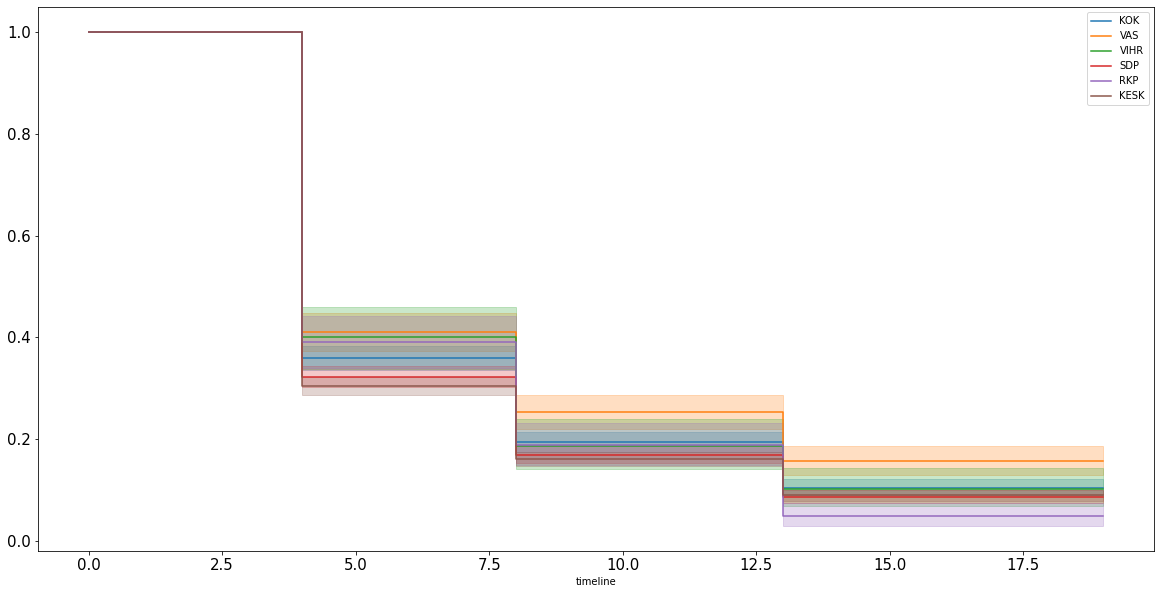

In [82]:
## Check for later analysis functioning of KaplanMeierFitter and the data

Time = ALL_04["Time"]
Event = ALL_04["Event"]

## Subplot

ax = plt.subplot(111)

## Create variables for each party
## I later noticed that not all are necessary interesting, i.e. SIT and YSIT, which are list for non-party affiliated candidates
## These would otherwise be interesting, but the names vary a lot, and for learning purposes I was not willing to refactor the data for small groups
KOK = (ALL_04["Party"] == "KOK")
VAS = (ALL_04["Party"] == "VAS")
VIHR = (ALL_04["Party"] == "VIHR")
SDP = (ALL_04["Party"] == "SDP")
RKP = (ALL_04["Party"] == "RKP")
KD = (ALL_04["Party"] == "KD")
SKP = (ALL_04["Party"] == "SKP")
KESK = (ALL_04["Party"] == "KESK")
PS = (ALL_04["Party"] == "PS")
SIT = (ALL_04["Party"] == "SIT")
YSIT = (ALL_04["Party"] == "YL SIT")

## Fit to KaplanMeierFitter

kmf.fit(Time[KOK], event_observed=Event[KOK], label="KOK", timeline=range(0,20,1))
kmf.plot(ax=ax)

## Calculate the median survival time

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median value

print('Kokoomus median:',median_)

## Repeat for all the parties

kmf.fit(Time[VAS], event_observed=Event[VAS], label="VAS", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('Vasemmistoliitto median:',median_)

kmf.fit(Time[VIHR], event_observed=Event[VIHR], label="VIHR", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('Vihreät median:',median_)

kmf.fit(Time[SDP], event_observed=Event[SDP], label="SDP", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('SDP median:',median_)

kmf.fit(Time[RKP], event_observed=Event[RKP], label="RKP", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('RKP median:',median_)

kmf.fit(Time[KESK], event_observed=Event[KESK], label="KESK", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('Keskusta median:',median_)

##kmf.fit(Time[PS], event_observed=Event[PS], label="PS", timeline=range(0,20,1))
##kmf.plot(ax=ax)
##median_ = kmf.median_survival_time_
##median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
##print('Perussuomalaiset median:',median_)

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_ALL_04_parties.png')

In [ ]:
## Save merged dataframe for later analysis

ALL_04.to_csv("candidate_persistence.csv")

In [ ]:
## Create a new dataframe of new councilmembers for later analysis

NEW_04 = ALL_04[ALL_04.Sitting == 0].copy()


In [ ]:
ALL_04.shape


In [ ]:
NEW_04.to_csv("new_candidate_persistence.csv")